# Previsão com Redes Neurais Recorrentes


In [1]:
import pandas as pd
from pandas import Grouper, DataFrame

from typing import Tuple, List, Callable, Dict

import numpy as np
import os
from datetime import datetime
import random
import time

from matplotlib import pyplot as plt
import seaborn as sns

import inspect
import warnings

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

import pickle

import tensorflow as tf

from math import ceil

## Constantes

In [60]:
DIR_DATASET: str = os.path.join('datasets', 'dados-gerados')

DATASET_OEC_MPME = os.path.join(DIR_DATASET,  'oec_mpme.csv')

DAT_CORRENTE = datetime.today().strftime("%Y-%m-%d")

TEST_SPLIT_SIZE = 8
VAL_SPLIT_SIZE = 15
WINDOW_SIZE = 24
MEAN_SQUARED_METRIC = "mean_squeared"
MEAN_ABSOLUTE_METRIC = "mean_absolute"
R2_METRIC = "r2"

MODEL_PATH = 'MODEL'
SCALER_FEATURE_FILE_NAME = os.path.join(MODEL_PATH, 'scaler-multivariate-feature.pkl')
SCALER_LABEL_FILE_NAME = os.path.join(MODEL_PATH, 'scaler-multivariate-label.pkl')

BATCH_SIZE = 100


## Funções

In [26]:
def create_scaler(ds: np.ndarray, limit: int = 0, filter_column: int = -1) -> MinMaxScaler:
    narray: np.ndarray = ds
    if limit > 0:
        narray = ds[:limit]
    if filter_column >= 0:
        narray = ds[:, filter_column].reshape(-1,1)
        
    scaler: MinMaxScaler = MinMaxScaler()
    scaler.fit(narray)
    return scaler
    

In [36]:
# Returns X_train, y_train, X_valid, y_valid, X_test, y_test
# A normalzação precisou ser feita no split porque a janela transformava o array em 3d,  o MinMaxScaler não aceita array 3d
def split_train_validation_test_window_dataset(full_dataset: np.ndarray, 
                                               label_column: int,
                                               val_percentual_size: int, 
                                               test_percentual_size: int, 
                                               window_size: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    #posições
    dataset_size: int = full_dataset.shape[0]
    cut_pos_test: int = round(dataset_size - (dataset_size * (test_percentual_size/100)))
    cut_pos_val: int = round(cut_pos_test - (dataset_size * (val_percentual_size/100)))
    
    # normalização
    scaler_feature: MinMaxScaler = create_scaler(full_dataset, cut_pos_val)
    pickle.dump(scaler_feature, open(SCALER_FEATURE_FILE_NAME, 'wb'))
    scaler_label: MinMaxScaler = create_scaler(full_dataset, cut_pos_val, label_column) 
    pickle.dump(scaler_label, open(SCALER_LABEL_FILE_NAME, 'wb'))    
        
    #tamanho splits
    test_dataset_size: int = dataset_size - cut_pos_test
    val_dataset_size: int = dataset_size - cut_pos_val - test_dataset_size
    
    y_train: np.ndarray = scaler_label.transform(full_dataset[window_size : cut_pos_val, label_column].reshape(-1,1)).squeeze()
    y_val: np.ndarray = scaler_label.transform(full_dataset[cut_pos_val : cut_pos_test, label_column].reshape(-1,1)).squeeze()
    y_test: np.ndarray = full_dataset[cut_pos_test:, label_column]
    
    train_dataset_list = [scaler_feature.transform(full_dataset[ind : ind + window_size, :]) for ind in range (cut_pos_val - window_size)]
    X_train = np.array(train_dataset_list)
    
    val_dataset_list = [scaler_feature.transform(full_dataset[cut_pos_val + ind - window_size :cut_pos_val + ind, :]) for ind in range (val_dataset_size)]
    X_valid = np.array(val_dataset_list)
    
    test_dataset_list = [scaler_feature.transform(full_dataset[cut_pos_test + ind - window_size :cut_pos_test + ind, :]) for ind in range (test_dataset_size)]
    X_test = np.array(test_dataset_list)
    
    return (X_train, y_train, X_valid, y_val, X_test, y_test)

## Carrega Datasets

In [61]:
df_oec_mpme = pd.read_csv(DATASET_OEC_MPME, sep=';', decimal=',', parse_dates=True)
df_oec_mpme.index = pd.DatetimeIndex(df_oec_mpme.data_base)
df_oec_mpme["ano_mes"] = pd.DatetimeIndex(df_oec_mpme.data_base).strftime('%Y-%m')
df_oec_mpme_multivariate = df_oec_mpme[['ano','mes', 'ano_mes', 'desembolso', 'vendas', 'aprovacao', 'ind_atv_econ', 'dif_custo_bndes_mercado']]

desembolso_multivariate = df_oec_mpme_multivariate[['desembolso', 'vendas', 'aprovacao', 'ind_atv_econ', 'dif_custo_bndes_mercado']].to_numpy()
#desembolso_time = df_oec_mpme_desembolso[["ano_mes"]].to_numpy().squeeze()

In [62]:
df_oec_mpme_multivariate.head(30)

,ano,mes,ano_mes,desembolso,vendas,aprovacao,ind_atv_econ,dif_custo_bndes_mercado
data_base,,,,,,,,
2009-10-01,2009,10,2009-10,1388.5,13123.0,1437.057832,129.78,-8.796206
2009-11-01,2009,11,2009-11,1339.9,13219.0,1497.107343,130.01,-9.062494
2009-12-01,2009,12,2009-12,1259.6,15104.0,1580.255803,131.36,-9.233439
2010-01-01,2010,1,2010-01,1682.7,11569.0,1853.163058,133.50,-9.156129
2010-02-01,2010,2,2010-02,1160.7,9581.0,1774.880889,135.18,-8.657825
2010-03-01,2010,3,2010-03,1493.0,16357.0,2011.935420,136.60,-8.443181
2010-04-01,2010,4,2010-04,1793.9,15936.0,1573.336032,137.18,-8.662085
2010-05-01,2010,5,2010-05,1972.8,15311.0,3598.773799,136.47,-8.764195
2010-06-01,2010,6,2010-06,2231.7,15272.0,2903.774521,136.20,-8.429926


In [63]:
scaler_features = MinMaxScaler()
scaler_labels = MinMaxScaler()

scaler_features.fit(X_train)
y_train = y_train.reshape(-1,1)
scaler_labels.fit(y_train)

X_train = scaler_features.transform(X_train)
y_train = scaler_labels.transform(y_train)
y_train.squeeze()

X_valid = scaler_features.transform(X_valid)
y_valid = scaler_labels.transform(y_valid)
y_valid.squeeze()

pickle.dump(scaler_features, open(SCALER_FEATURES_FILE_NAME, 'wb'))
pickle.dump(scaler_labels, open(SCALER_FEATURES_FILE_NAME, 'wb'))

ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

In [65]:
(X_train, y_train, X_valid, y_valid, X_test, y_test) = split_train_validation_test_window_dataset(full_dataset=desembolso_multivariate, 
                                                                                                  label_column=0,
                                                                                                  val_percentual_size=VAL_SPLIT_SIZE, 
                                                                                                  test_percentual_size=TEST_SPLIT_SIZE, 
                                                                                                  window_size=WINDOW_SIZE)

In [54]:
print(X_train)
print(y_train)


[[[0.34612228 0.57838884 0.27627739 0.         0.24055647]
  [0.3318776  0.58401735 0.28923548 0.01220807 0.22025222]
  [0.30834164 0.69453565 0.30717809 0.08386412 0.20721781]
  ...
  [0.51046368 0.88004221 0.3829249  0.65658174 0.47877014]
  [0.47772437 0.95696529 0.38539944 0.64755839 0.52461323]
  [0.46025558 0.86890244 0.37269637 0.63800425 0.55659019]]

 [[0.3318776  0.58401735 0.28923548 0.01220807 0.22025222]
  [0.30834164 0.69453565 0.30717809 0.08386412 0.20721781]
  [0.43235242 0.4872772  0.36606877 0.19745223 0.21311263]
  ...
  [0.47772437 0.95696529 0.38539944 0.64755839 0.52461323]
  [0.46025558 0.86890244 0.37269637 0.63800425 0.55659019]
  [0.49144147 0.79432458 0.53608828 0.62738854 0.57058806]]

 [[0.30834164 0.69453565 0.30717809 0.08386412 0.20721781]
  [0.43235242 0.4872772  0.36606877 0.19745223 0.21311263]
  [0.27935401 0.37071998 0.34917625 0.2866242  0.25110799]
  ...
  [0.46025558 0.86890244 0.37269637 0.63800425 0.55659019]
  [0.49144147 0.79432458 0.5360882

In [66]:
n_samples = X_train.shape[0] # samples
n_timesteps = X_train.shape[1] # window_size
n_features =  desembolso_multivariate.shape[1] #multivariate

#X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features)
#X_valid_rs = X_valid.reshape(X_valid.shape[0], n_timesteps, n_features)

In [67]:
print(n_samples, n_timesteps, n_features)

88 24 5


---
### Multivariate LSTM

In [68]:
# RNN recebe input_shape no seguinte formato
# (N,T,D), where N is the number of samples, T is length of time sequence and D is the number of features

lstm_model = tf.keras.models.Sequential([
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), input_shape=(n_timesteps,n_features)),
    tf.keras.layers.LSTM(100, input_shape=(n_timesteps,n_features), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=50,return_sequences=False)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(20, activation='softmax'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1),
])

lstm_model.compile(optimizer='adam', loss='mse')


In [69]:
model_multivariate_path = os.path.join(MODEL_PATH, 'model-lstm-desembolso-multivariate.h5')

history = lstm_model.fit(x=X_train,
                         y=y_train,
                         validation_data=(X_valid, y_valid),
                         epochs=150,
                         shuffle=False,
                         batch_size=BATCH_SIZE,
                         callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10,verbose=1, mode='min'),
                                     tf.keras.callbacks.ModelCheckpoint(model_multivariate_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
                        )

Epoch 1/150
1/1 [==============================] - 2s 2s/step - loss: 0.0980 - val_loss: 0.0014
Epoch 2/150
1/1 [==============================] - 0s 59ms/step - loss: 0.0887 - val_loss: 0.0012
Epoch 3/150
1/1 [==============================] - 0s 59ms/step - loss: 0.0861 - val_loss: 0.0012
Epoch 4/150
1/1 [==============================] - 0s 40ms/step - loss: 0.0797 - val_loss: 0.0014
Epoch 5/150
1/1 [==============================] - 0s 40ms/step - loss: 0.0744 - val_loss: 0.0020
Epoch 6/150
1/1 [==============================] - 0s 38ms/step - loss: 0.0692 - val_loss: 0.0030
Epoch 7/150
1/1 [==============================] - 0s 38ms/step - loss: 0.0629 - val_loss: 0.0048
Epoch 8/150
1/1 [==============================] - 0s 38ms/step - loss: 0.0604 - val_loss: 0.0077
Epoch 9/150
1/1 [==============================] - 0s 38ms/step - loss: 0.0522 - val_loss: 0.0121
Epoch 10/150
1/1 [==============================] - 0s 37ms/step - loss: 0.0497 - val_loss: 0.0183
Epoch 11/150
1/1 [===

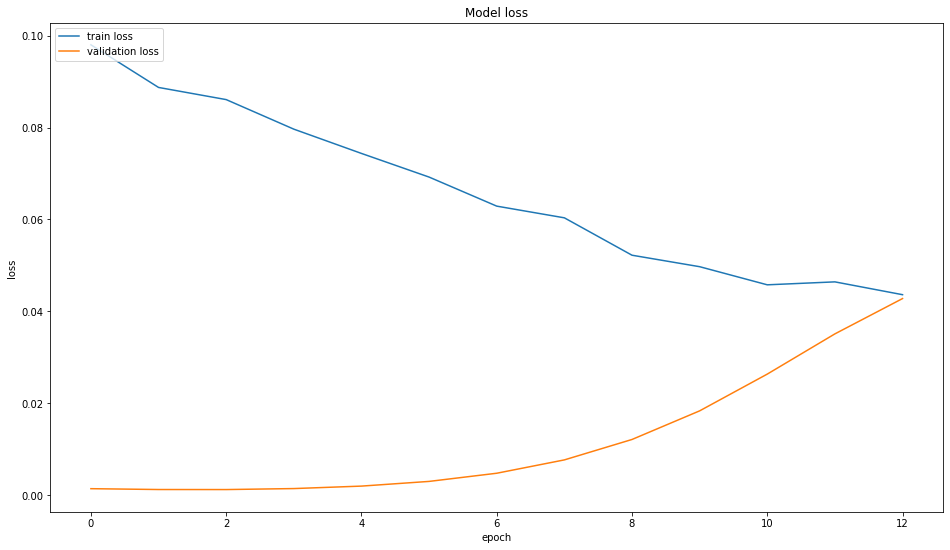

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [71]:
model_multivariate = tf.keras.models.load_model(model_multivariate_path)

In [72]:
#X_test_rs = X_test.reshape(X_test.shape[0], WINDOW_SIZE, 1)

y_predict = model_multivariate.predict(X_test)
y_predict = scaler.inverse_transform(y_predict)

y_predict_univariate_lstm = y_predict.squeeze()
y_true_univariate_lstm = y_test

NameError: name 'scaler' is not defined

In [73]:
y_predict

array([[0.06388573],
       [0.06365161],
       [0.0634625 ],
       [0.06331674],
       [0.06329621],
       [0.06333694],
       [0.06346372],
       [0.06364734],
       [0.06386131],
       [0.06411675],
       [0.06438522],
       [0.06464545]], dtype=float32)

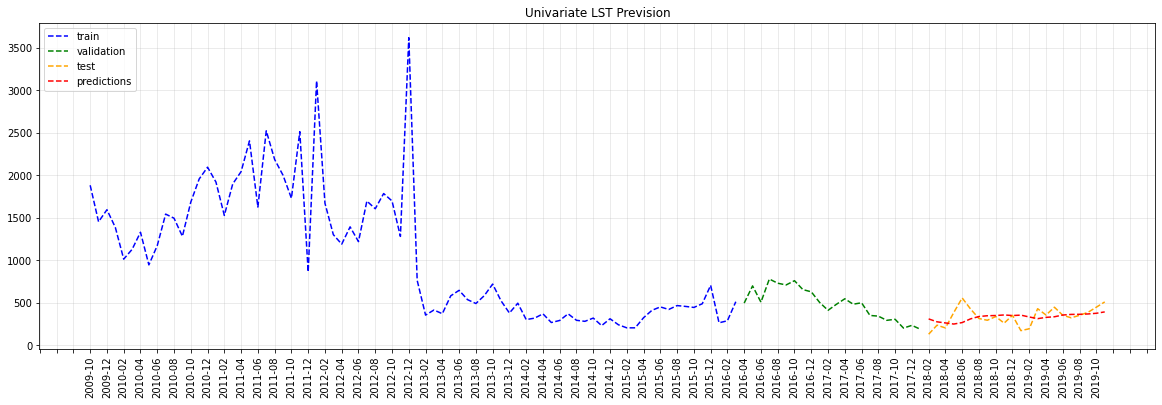

In [13]:
y_train_rs = y_train.reshape(-1,1)
y_train_rs = scaler.inverse_transform(y_train_rs)
y_train_rs = y_train_rs.squeeze()

y_valid_rs = y_valid.reshape(-1,1)
y_valid_rs = scaler.inverse_transform(y_valid_rs)
y_valid_rs = y_valid_rs.squeeze()

len_train = len(y_train_rs)
len_with_valid = len(y_train_rs) + len(y_valid_rs)
len_with_test = len(y_train) + len(y_valid) + len(y_test)

plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.plot(desembolso_time[:len_train], y_train_rs, 'b--', label="train")
plt.plot(desembolso_time[len_train:len_with_valid], y_valid_rs, color='green', linestyle="--", label="validation")
plt.plot(desembolso_time[len_with_valid:len_with_test], y_true_univariate_lstm, color='orange', linestyle='--', label="test")
plt.plot(desembolso_time[len_with_valid:len_with_test], y_predict_univariate_lstm, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title(f"Univariate LST Prevision")
plt.grid(alpha=0.3);

In [14]:
univariate_lstm_mse = mean_squared_error(y_true, y_predict_univariate_lstm, squared=True)
univariate_lstm_mae = mean_absolute_error(y_true, y_predict_univariate_lstm)
univariate_lstm_r2 = r2_score(y_true, y_predict_univariate_lstm)
print(f'Mean Squared Error: {univariate_lstm_mse} ')
print(f'Mean Absolute Error: {univariate_lstm_mae}')
print(f'R2 Score: {univariate_lstm_r2}')

Mean Squared Error: 12108.390273576451 
Mean Absolute Error: 83.98440533895598
R2 Score: -0.05813091229162537
